In [1]:
import json

from huggingface_hub import login
# api_key_path = "/home/paperspace/api_keys.json"
# with open(api_key_path, 'r') as j:
#     key = json.loads(j.read())['hf-llama']

login(token=key)
    
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from graspologic.embed import ClassicalMDS

from sentence_transformers import SentenceTransformer
from datasets import load_dataset, concatenate_datasets

from tqdm import tqdm
from taxi import utils, taxi

EMBEDDING_MODEL = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device='cuda:0')

%load_ext autoreload
%autoreload 2

!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>


In [2]:
import gc
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    PeftModel,
    PeftConfig
)

import torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes as procrustes


model_id = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True
)
tokenizer.padding_token = tokenizer.eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side='right'


def get_fine_pis(coarse_pi, coarse_to_fine_dict):
    fine_topics = []
    fine_pi = []
    
    for i, coarse in enumerate(coarse_to_fine_dict):
        for fine in coarse_to_fine_dict[coarse]:
            fine_topics.append(fine)
            fine_pi.append(coarse_pi[coarse] / len(coarse_to_fine_dict[coarse]))
            
    return tuple(fine_topics), tuple(fine_pi)


def pi_to_string(pi):
    s=""
    for c in pi[:-1]:
        s+= str(int(100*c // 1)).zfill(3) + '_'
        
    s+=str(int(100 * pi[-1] // 1)).zfill(3)
    
    return s

In [ ]:
TRAIN=True

# group 1: Health (2), Sports (5), Family (8)
# group 2: Politics (9), business (6), society and culture (0)
# group 3: Computers (4), Entertainment (7), Education (3) 
coarse_to_fine_dict = {
    0: (2,5,8),
    1: (9,6,0),
    2: (4,7,3)
}

dataset_name = 'community-datasets/yahoo_answers_topics'
topic_key = 'topic'

lora_rank_list = [8, 16, 32, 128]
N_list = [10,50,100,500,1000,5000,10000]
n_mc=5

cache_dir = '~/.cache/huggingface/datasets'
for N in N_list:
    N_str = str(N).zfill(5)
    
    for lora_rank in lora_rank_list:
        print(N, lora_rank)
                
        lora_config = LoraConfig(
            r=lora_rank,  # Reduced rank for 8B model
            lora_alpha=2*lora_rank,
            lora_dropout=0,
            bias="none",
            task_type="CAUSAL_LM",
            target_modules=[
                "q_proj",
                "k_proj",
                "v_proj"
            ]
        )
        
        lora_rank_str = str(lora_rank).zfill(3)
        for mc in range(n_mc):
            datasets = {}
            # lora_matrices = {}
            # normed_average_hidden_states = {}
            # responses = {}
            
            ### Update true_pi_list here if necessary
            true_pi_list = [(1,0,0), (0,1,0), (0,0,1), (1/3,1/3,1/3)]
                                                       
            for true_pi in true_pi_list:
                fine_topics, fine_pi = get_fine_pis(true_pi, coarse_to_fine_dict)
                
                save_string = f'./models/N_{N_str}_lora_{lora_rank_str}_id_{mc}_pi_{pi_to_string(true_pi)}'
                if os.path.exists(save_string) and TRAIN:
                    continue
                
                datasets[true_pi] = utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, N, cache_dir=cache_dir, seed=mc)
                
                if 'base_model' not in locals():
                    base_model = AutoModelForCausalLM.from_pretrained(
                            model_id,
                            torch_dtype=torch.float16,
                            device_map="cuda:0",
                            trust_remote_code=True
                    )
                
                if TRAIN:
                    tokenized_dataset = utils._prepare_dataset(datasets[true_pi], tokenizer, 'question_title', 'best_answer')
                    
                    # Prepare model for training
                    model = prepare_model_for_kbit_training(base_model)
                    model = get_peft_model(model, lora_config)
                    
                    # Initialize trainer
                    training_args = TrainingArguments(
                        output_dir=save_string,
                        num_train_epochs=3,
                        per_device_train_batch_size=4,
                        gradient_accumulation_steps=1,
                        learning_rate=1e-5,  
                        fp16=True,
                        save_strategy='no',
                        logging_steps=10,
                        optim="paged_adamw_8bit",
                        lr_scheduler_type="cosine"
                    )

                    trainer = Trainer(
                        model=model,
                        args=training_args,
                        train_dataset=tokenized_dataset,
                        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
                    )

                    # Start training
                    trainer.train()
                    model.save_pretrained(save_string)
                else:
                    # Load base model
                    model = PeftModel.from_pretrained(
                                base_model,
                                save_string,
                                torch_dtype=torch.float16,
                                device_map='cuda:0'
                    )
                                

                # responses[true_pi], normed_average_hidden_states[true_pi] = taxi.get_outputs(model, tokenizer, query_set, match_n_input_tokens=True)
                # lora_matrices[true_pi] = taxi.get_lora_matrices(model)

                            
                try:
                    del model
                    torch.cuda.empty_cache()
                    gc.collect()
                except:
                    pass

            # cached_data[N][lora_rank][mc]['behavioral'] = responses.copy()
            # cached_data[N][lora_rank][mc]['functional'] = normed_average_hidden_states.copy()
            # cached_data[N][lora_rank][mc]['structural'] = lora_matrices.copy()

            
            # pickle.dump(cached_data, open(cache_file_path, 'wb'))
        
try:
    base_model.cpu()
    del base_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

10 8


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

10 16


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

10 32


10 128


50 8


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

50 16


50 32


50 128


100 8


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

100 16


100 32


100 128


500 8


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

500 16


500 32


500 128


1000 8


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

1000 16


1000 32


1000 128


5000 8


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

5000 16


5000 32


Using the latest cached version of the dataset since community-datasets/yahoo_answers_topics couldn't be found on the Hugging Face Hub


Using the latest cached version of the dataset since community-datasets/yahoo_answers_topics couldn't be found on the Hugging Face Hub


10000 32


Using the latest cached version of the dataset since community-datasets/yahoo_answers_topics couldn't be found on the Hugging Face Hub


In [4]:
base_model = AutoModelForCausalLM.from_pretrained(
                            model_id,
                            torch_dtype=torch.float16,
                            device_map="cuda:0",
                            trust_remote_code=True
                    )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt



In [5]:
#- Keep this just in case you need it in a few mins / next session
try:
    base_model.cpu()
    del base_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

In [52]:
cached_data = pickle.load(open(cache_file_path, 'rb'))

geometries = {}

true_pi_list = [(1,0,0), (0,1,0), (0,0,1), (1/3,1/3,1/3)]
dist_pis = squareform(pdist(true_pi_list))
dist_pis /= np.linalg.norm(dist_pis)
true_geometry = ClassicalMDS(n_components=3).fit_transform(dist_pis)

query_set_size_list = [1,2,5,10,20,50,100]

# complete_datasets = []
# for pi in true_pi_list[:-1]:
#     fine_topics, fine_pi = get_fine_pis(pi, coarse_to_fine_dict)
#     complete_datasets.append(utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, 14000*3, seed=mc))

for N in tqdm(N_list):
    geometries[N] = {}
    for lora_rank in lora_rank_list:
        geometries[N][lora_rank] = {}
        for mc in tqdm(range(4)):
            datasets = {}
            for pi in true_pi_list:
                dataset_size_list = []
                dataset_size = [int(N * pi_component) for pi_component in pi]
                remainder = N - np.sum(dataset_size)

                for i in np.random.choice(range(len(complete_datasets)), size=remainder):
                    dataset_size[i] += 1

                
                datasets[pi] = utils._merge_datasets([cd.shuffle(seed=mc).select(range(dataset_size[i])) for i, cd in enumerate(complete_datasets)])

            
            geometries[N][lora_rank][mc] = {}
            data_geometry = taxi.get_dataset_geometry(true_geometry, 
                                                      datasets, 
                                                      EMBEDDING_MODEL
                                                     )
            structural_geometry = taxi.get_structural_geometry(true_geometry, 
                                                               cached_data[N][lora_rank][mc]['structural']
                                                              )

            for query_set_size in query_set_size_list:
                geometries[N][lora_rank][mc][query_set_size] = {}

                not_unique_responses=True
                attempts=0
                while not_unique_responses:
                    query_indices = np.random.choice(500, query_set_size, replace=False).astype(int)
                    attempts+=1
    
                    responses = {}
                    normed_average_hidden_states = {}
    
                    for pi in true_pi_list:
                        normed_average_hidden_states[pi] = cached_data[N][lora_rank][mc]['functional'][pi][query_indices]
                        responses[pi] = np.array(cached_data[N][lora_rank][mc]['behavioral'][pi])[query_indices]

                    try:
                        geometries[N][lora_rank][mc][query_set_size]['behavioral'] = taxi.get_behavioral_geometry(true_geometry, 
                                                                                                          responses,
                                                                                                          EMBEDDING_MODEL
                                                                                                         )
                        not_unique_responses=False
                    except:
                        print(N, lora_rank, mc, query_set_size, attempts)
                
                
                
                geometries[N][lora_rank][mc][query_set_size]['functional'] = taxi.get_functional_geometry(true_geometry,
                                                                                                          normed_average_hidden_states
                                                                                                         )
                geometries[N][lora_rank][mc][query_set_size]['data'] = data_geometry
                geometries[N][lora_rank][mc][query_set_size]['structural'] = structural_geometry
                geometries[N][lora_rank][mc][query_set_size]['true'] = true_geometry

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 0 1 1
10 64 0 1 2
10 64 0 1 3
10 64 0 1 4
10 64 0 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 0 1 6
10 64 0 1 7
10 64 0 1 8
10 64 0 1 9
10 64 0 1 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 0 1 11
10 64 0 2 1
10 64 0 2 2


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 0 5 1



 25%|█████████████████████▎                                                               | 1/4 [00:07<00:23,  7.73s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 1 1
10 64 1 1 2
10 64 1 1 3
10 64 1 1 4
10 64 1 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 1 6
10 64 1 1 7
10 64 1 1 8
10 64 1 1 9


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 1
10 64 1 2 2
10 64 1 2 3
10 64 1 2 4
10 64 1 2 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 6
10 64 1 2 7
10 64 1 2 8
10 64 1 2 9
10 64 1 2 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 11
10 64 1 2 12
10 64 1 2 13
10 64 1 2 14
10 64 1 2 15


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 16
10 64 1 2 17
10 64 1 2 18
10 64 1 2 19
10 64 1 2 20


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 21
10 64 1 2 22
10 64 1 2 23
10 64 1 2 24
10 64 1 2 25


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 26
10 64 1 2 27
10 64 1 2 28
10 64 1 2 29
10 64 1 2 30


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 31
10 64 1 2 32
10 64 1 2 33
10 64 1 2 34
10 64 1 2 35


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 36
10 64 1 2 37
10 64 1 2 38
10 64 1 2 39
10 64 1 2 40


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 41
10 64 1 2 42
10 64 1 2 43
10 64 1 2 44
10 64 1 2 45


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 46
10 64 1 2 47
10 64 1 2 48
10 64 1 2 49
10 64 1 2 50


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 2 51
10 64 1 2 52
10 64 1 2 53
10 64 1 2 54
10 64 1 2 55


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 5 1
10 64 1 5 2
10 64 1 5 3
10 64 1 5 4


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 20 1
10 64 1 50 1


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 1 50 2



 50%|██████████████████████████████████████████▌                                          | 2/4 [00:19<00:19,  9.95s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 1 1
10 64 2 1 2
10 64 2 1 3
10 64 2 1 4
10 64 2 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 1 6
10 64 2 1 7
10 64 2 1 8
10 64 2 1 9
10 64 2 1 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 1 11
10 64 2 1 12
10 64 2 1 13
10 64 2 1 14
10 64 2 1 15


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 1 16
10 64 2 1 17
10 64 2 1 18
10 64 2 1 19
10 64 2 1 20


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 1 21
10 64 2 1 22
10 64 2 1 23
10 64 2 1 24


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 2 1
10 64 2 2 2
10 64 2 2 3
10 64 2 2 4
10 64 2 2 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 2 6
10 64 2 2 7
10 64 2 2 8
10 64 2 2 9


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 5 1
10 64 2 5 2
10 64 2 5 3
10 64 2 5 4


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 2 20 1
10 64 2 20 2



 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:29<00:09,  9.95s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 1
10 64 3 1 2
10 64 3 1 3
10 64 3 1 4
10 64 3 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 6
10 64 3 1 7
10 64 3 1 8
10 64 3 1 9
10 64 3 1 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 11
10 64 3 1 12
10 64 3 1 13
10 64 3 1 14
10 64 3 1 15


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 16
10 64 3 1 17
10 64 3 1 18
10 64 3 1 19
10 64 3 1 20


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 21
10 64 3 1 22
10 64 3 1 23
10 64 3 1 24
10 64 3 1 25


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 26
10 64 3 1 27
10 64 3 1 28
10 64 3 1 29
10 64 3 1 30


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 31
10 64 3 1 32
10 64 3 1 33
10 64 3 1 34
10 64 3 1 35


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 36
10 64 3 1 37
10 64 3 1 38
10 64 3 1 39
10 64 3 1 40


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 1 41
10 64 3 1 42
10 64 3 1 43
10 64 3 1 44
10 64 3 1 45


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 2 1
10 64 3 2 2
10 64 3 2 3
10 64 3 2 4
10 64 3 2 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 2 6
10 64 3 2 7
10 64 3 5 1
10 64 3 5 2


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 5 3
10 64 3 5 4
10 64 3 5 5
10 64 3 5 6
10 64 3 5 7


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 5 8
10 64 3 5 9
10 64 3 5 10
10 64 3 5 11
10 64 3 5 12


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 10 1
10 64 3 10 2
10 64 3 10 3
10 64 3 10 4
10 64 3 10 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 10 6
10 64 3 10 7
10 64 3 10 8
10 64 3 10 9
10 64 3 10 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10 64 3 20 1
10 64 3 20 2



  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 0 1 1
50 64 0 5 1
50 64 0 5 2


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 0 10 1



 25%|█████████████████████▎                                                               | 1/4 [00:09<00:28,  9.35s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 1 1 1
50 64 1 1 2
50 64 1 1 3
50 64 1 1 4
50 64 1 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 1 1 6
50 64 1 2 1
50 64 1 2 2
50 64 1 2 3


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 1 2 4
50 64 1 2 5
50 64 1 2 6
50 64 1 2 7
50 64 1 2 8


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 1 2 9
50 64 1 2 10
50 64 1 2 11
50 64 1 2 12
50 64 1 2 13


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 1 2 14
50 64 1 2 15
50 64 1 2 16
50 64 1 5 1


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 1 10 1



 50%|██████████████████████████████████████████▌                                          | 2/4 [00:19<00:20, 10.05s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 2 1 1
50 64 2 1 2
50 64 2 1 3
50 64 2 1 4
50 64 2 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 2 1 6
50 64 2 1 7
50 64 2 1 8
50 64 2 1 9
50 64 2 1 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 2 1 11
50 64 2 5 1


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 2 10 1
50 64 2 20 1



 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:29<00:10, 10.04s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 1 1
50 64 3 1 2
50 64 3 1 3
50 64 3 1 4
50 64 3 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 1 6
50 64 3 2 1
50 64 3 2 2
50 64 3 2 3


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 2 4
50 64 3 2 5
50 64 3 2 6
50 64 3 2 7
50 64 3 2 8


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 2 9
50 64 3 2 10
50 64 3 5 1
50 64 3 5 2


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 5 3
50 64 3 5 4
50 64 3 5 5
50 64 3 5 6
50 64 3 5 7


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 5 8
50 64 3 5 9


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


50 64 3 20 1



  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 0 1 1
100 64 0 1 2
100 64 0 1 3
100 64 0 1 4
100 64 0 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 0 1 6



 25%|█████████████████████▎                                                               | 1/4 [00:09<00:29,  9.95s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 1 1 1
100 64 1 1 2
100 64 1 1 3
100 64 1 1 4
100 64 1 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 1 1 6
100 64 1 1 7
100 64 1 1 8
100 64 1 1 9
100 64 1 1 10


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 1 1 11
100 64 1 1 12
100 64 1 2 1
100 64 1 2 2


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 1 2 3
100 64 1 2 4
100 64 1 2 5



 50%|██████████████████████████████████████████▌                                          | 2/4 [00:20<00:20, 10.21s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 2 1 1
100 64 2 1 2
100 64 2 1 3
100 64 2 1 4
100 64 2 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 2 1 6
100 64 2 1 7
100 64 2 5 1


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 2 5 2
100 64 2 5 3
100 64 2 5 4
100 64 2 5 5
100 64 2 5 6


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 2 5 7
100 64 2 5 8



 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:30<00:10, 10.18s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 3 1 1
100 64 3 1 2
100 64 3 1 3
100 64 3 1 4
100 64 3 1 5


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


100 64 3 1 6
100 64 3 1 7
100 64 3 1 8
100 64 3 1 9



 50%|██████████████████████████████████████████▌                                          | 2/4 [00:23<00:23, 11.94s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


500 64 2 1 1
500 64 2 1 2
500 64 2 1 3
500 64 2 2 1


/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


500 64 2 2 2
500 64 2 2 3



 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:35<00:12, 12.02s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


500 64 3 1 1



  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


1000 64 0 2 1



 25%|█████████████████████▎                                                               | 1/4 [00:15<00:47, 15.89s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


1000 64 1 2 1



 50%|██████████████████████████████████████████▌                                          | 2/4 [00:31<00:31, 15.79s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


1000 64 2 2 1
1000 64 2 2 2
1000 64 2 2 3



 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:47<00:15, 15.81s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)
/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


1000 64 3 1 1
1000 64 3 1 2
1000 64 3 1 3



 50%|██████████████████████████████████████████▌                                          | 2/4 [01:50<01:50, 55.50s/it]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


5000 64 2 1 1



  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/paperspace/taxonomic-ai/taxi/taxi.py:216: RuntimeWarning: invalid value encountered in divide
  dist_behavioral /= np.linalg.norm(dist_behavioral)


10000 64 0 1 1



100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [14:34<00:00, 124.96s/it]


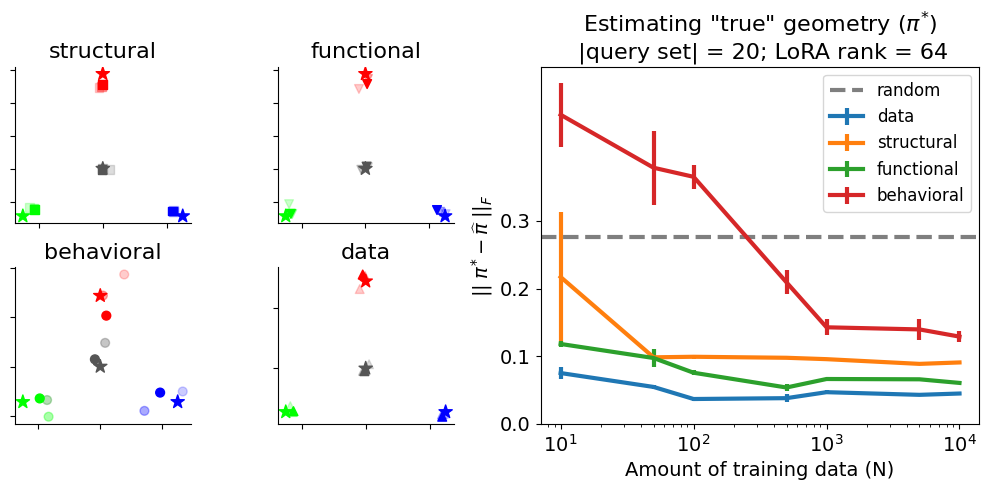

In [63]:
#- Set up fig structure
def get_random_geometry(true_geometry):
    n, n_components=true_geometry.shape
    vectors = np.random.random(size=(n, n_components))
    
    dist_matrix = squareform(pdist(vectors))
    dist_matrix /= np.linalg.norm(dist_matrix)
    
    cmds = ClassicalMDS(n_components=n_components).fit_transform(dist_matrix)
    
    return utils._rotate_geometry(true_geometry, cmds)


fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2, 4)

true_pi_list = [(1,0,0), (0,1,0), (0,0,1), (1/3,1/3,1/3)]

lora_rank = 64
query_set_size=20
N_list = [10,50,100,500,1000,5000,10000]
n_mc=4
mc=0

alpha_dict = {50: 1/5, 500: 1/3, 5000: 1}
marker_dict = {'data': '^', 'structural': 's', 'functional': 'v', 'behavioral': 'o'}

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[:2, 2:4])
ax5.set_title(r'Estimating "true" geometry ($\pi^{*}$)' + f'\n |query set| = {query_set_size}; LoRA rank = {lora_rank}', fontsize=16)

#- Plot dots
ax = [ax1,ax2,ax3,ax4]
title_dict = {'data': 'data',
             'structural': 'structural',
             'functional': 'functional',
             'behavioral': 'behavioral'
}

for i, key in enumerate(title_dict):
    if key == 'true':
        continue
        
    i -= 1
    ax[i].scatter(true_geometry[:, 0], true_geometry[:, 1], c=true_pi_list, marker='*', s=100, alpha=alpha_dict[5000])
    
    for N in N_list:
        if N not in alpha_dict:
            continue

        geometry = geometries[N][lora_rank][mc][query_set_size][key]

        alpha=alpha_dict[N]
        ax[i].scatter(geometry[:, 0], geometry[:, 1], 
                   c=true_pi_list, marker=marker_dict[key], alpha=alpha, s=40)

    xlim, ylim = ax[i].get_xlim(), ax[i].get_ylim()
    
#     ax[row,col].scatter(100, 100, marker=marker_dict[key], c='k', alpha=alpha)
#     ax[row,col].scatter(100, 100, marker='*', label='true geometry', c='k', s=50)
    ax[i].set_xlim(*xlim), ax[i].set_ylim(*ylim)
    ax[i].set_title(f'{title_dict[key]}', fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    

#- Calculate average estimation error
distance_dict = {key: {} for key in title_dict if key != 'true'}

n_components=3
for N in N_list:
    for type_ in distance_dict:
        distance_dict[type_][N] = []
    for mc in range(n_mc):
        # if N == 5000 and mc > 0:
        #     continue

        # if mc not in cached_geometries['true'][N][64]:
        #     continue
            
        temp_true = geometries[N][lora_rank][mc][query_set_size]['true']
        for key in title_dict:
            if key == 'true':
                continue
        
            geometry = geometries[N][lora_rank][mc][query_set_size][key]
            distance_dict[key][N].append(np.linalg.norm(geometry[:,:n_components] - true_geometry[:,:n_components]))
            
#- Plot average estimation errors
ax5.set_xticks(N_list)
ax5.set_xlabel('Amount of training data (N)', fontsize=14)
ax5.set_ylabel(r'$ ||\;\pi^{*} - \widehat{\pi}\;||_{F} $', fontsize=14)

for key in distance_dict:
    mean_list = [np.mean(distance_dict[key][N]) for N in N_list]
    std_list = [np.std(distance_dict[key][N]) / np.sqrt(n_mc) for N in N_list]
    
    ax5.errorbar(N_list, mean_list, std_list, label=title_dict[key], lw=3)
    
random_errors = [np.linalg.norm(get_random_geometry(true_geometry) - true_geometry) for i in range(1000)]

ax5.axhline(y = np.mean(random_errors), c='k', lw=3, ls='--', alpha=0.5, label='random')
    
ax5.set_yticks([0, 0.1, 0.2, 0.3])
ax5.set_xscale('log')
ax5.tick_params(labelsize=14)
ax5.legend(fontsize=12)
    
plt.tight_layout()

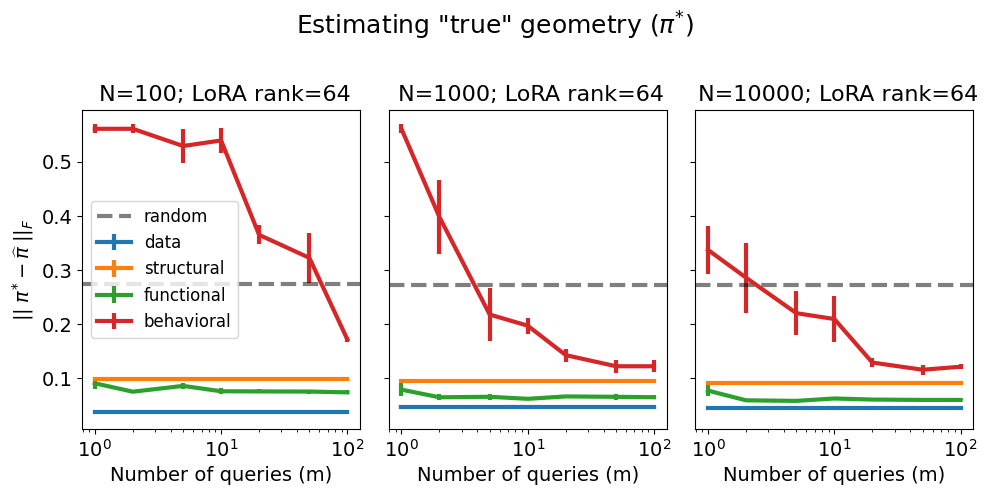

In [84]:
lora_rank = 64
N=1000
query_set_size_list = [1,2,5,10,20,50,100]
n_mc=4

fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True, sharex=True)
abbr_N_list = [100,1000,10000]

for i, ax in enumerate(axs):
    N = abbr_N_list[i]
    ax.set_title(f'\n N={N}; LoRA rank={lora_rank}', fontsize=16)
    
    #- Calculate average estimation error
    distance_dict = {key: {} for key in title_dict if key != 'true'}
    
    n_components=3
    for query_set_size in query_set_size_list:
        for type_ in distance_dict:
            distance_dict[type_][query_set_size] = []
        for mc in range(n_mc):
                
            temp_true = geometries[N][lora_rank][mc][query_set_size]['true']
            for key in title_dict:
                if key == 'true':
                    continue
            
                geometry = geometries[N][lora_rank][mc][query_set_size][key]
                distance_dict[key][query_set_size].append(np.linalg.norm(geometry[:,:n_components] - true_geometry[:,:n_components]))
                
    #- Plot average estimation errors
    ax.set_xticks(query_set_size_list)
    ax.set_xlabel('Number of queries (m)', fontsize=14)
    
    
    for key in distance_dict:
        mean_list = [np.mean(distance_dict[key][query_set_size]) for query_set_size in query_set_size_list]
        std_list = [np.std(distance_dict[key][query_set_size]) / np.sqrt(n_mc) for query_set_size in query_set_size_list]
        
        ax.errorbar(query_set_size_list, mean_list, std_list, label=title_dict[key], lw=3)
        
    random_errors = [np.linalg.norm(get_random_geometry(true_geometry) - true_geometry) for i in range(1000)]
    
    ax.axhline(y = np.mean(random_errors), c='k', lw=3, ls='--', alpha=0.5, label='random')
        
    # ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_xscale('log')
    ax.tick_params(labelsize=14)

    if i == 0:
        ax.legend(fontsize=12)
        ax.set_ylabel(r'$ ||\;\pi^{*} - \widehat{\pi}\;||_{F} $', fontsize=14)

fig.suptitle(r'Estimating "true" geometry ($\pi^{*}$)', fontsize=18)
    
plt.tight_layout()